# **Import libraries**

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import keras
from keras import layers
import tensorflow as tf
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-04-25 00:43:55.513733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 00:43:55.513871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 00:43:55.638208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Use GPU device**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **DNA Sequence Classification**

# Data Preprocessing

In [4]:
#
# Load data from file path
#
def read_data(path):
  f = open(path)
  text = f.read()
  datas = re.split('\n\n',text)
  for i in range(len(datas)):
      x = re.split('\n', datas[i])
      dna_sequence = ''
      for j in range(1, len(x)):
          dna_sequence += x[j]
      datas[i] = dna_sequence
  return datas

In [5]:
#
# Convert data from character to number
#
mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in mapping.keys()):
                check = True
                break
            arr.append(mapping[row[i]])
        if(check == False):
            results.append(arr)
    return results


In [9]:
#
# Reading data
#
mers_data = read_data('/kaggle/input/dna-sequence/MERS.fasta')
sars_data = read_data('/kaggle/input/dna-sequence/SARS.fasta')
covid_data = read_data('/kaggle/input/dna-sequence/COVID-19-2.fasta')
dengue_data = read_data('/kaggle/input/dna-sequence/dengue.fasta')

In [29]:
#
# Encoding data
#
mers_encoding = data_preprocessing(mers_data)
sars_encoding = data_preprocessing(sars_data[:3000])
covid_encoding = data_preprocessing(covid_data)
dengue_encoding = data_preprocessing(dengue_data)
# influenza_encoding = data_preprocessing(influenza_data)
# hepatitis_encoding = data_preprocessing(hepatitis_data)

In [30]:
#
# Labeling data
#
mers_label = [0] * len(mers_encoding)
sars_label = [1] * len(sars_encoding)
covid_label = [2] * len(covid_encoding)
# influenza_label = [3] * len(influenza_encoding)
dengue_label = [3] * len(dengue_encoding)
# hepatitis_label = [4] * len(hepatitis_encoding)

In [31]:
#
# Create data with DataFrame format
#
train_data = pd.DataFrame({'dna': mers_encoding + sars_encoding + covid_encoding + dengue_encoding, 'label': mers_label + sars_label + covid_label +dengue_label})
train_data.head()

,dna,label
0,"[1, 3, 4, 3, 1, 1, 4, 1, 3, 2, 4, 4, 3, 3, 2, ...",0
1,"[1, 2, 4, 1, 4, 1, 3, 2, 4, 3, 1, 4, 2, 2, 4, ...",0
2,"[3, 1, 2, 1, 1, 1, 3, 4, 2, 1, 2, 4, 1, 4, 1, ...",0
3,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0
4,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0


<Axes: xlabel='label', ylabel='count'>

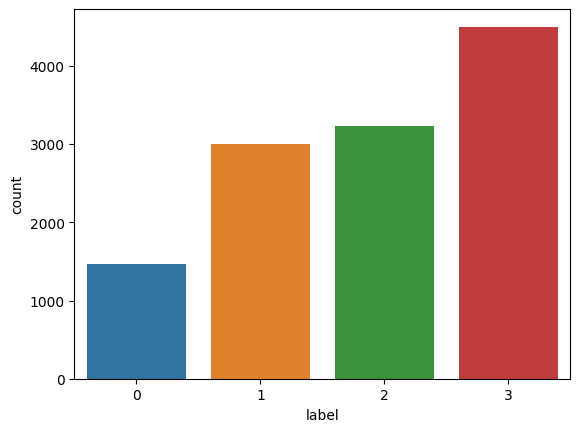

In [32]:
#
# Statistic label for each disease
#
sns.countplot(data=train_data, x = 'label')

In [33]:
#
# get max_length to padding sequence 
# Note that: Devide 2 because devices are not enough :v bruh
#
# max_length = int(max([len(x) for x in train_data['dna']]) / 3)
max_length = 1000
max_length

1000

# Create model

In [37]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train model

In [38]:
data_padding = pad_sequences(train_data['dna'], maxlen=max_length,value=0,padding='post')

In [39]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [40]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data_padding, y_tf, test_size = 0.2, random_state=42)

In [41]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(dna_train ,label_train, batch_size=32, epochs=7)

Epoch 1/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7456 - loss: 0.6614
Epoch 2/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9475 - loss: 0.1716
Epoch 3/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9768 - loss: 0.0794
Epoch 4/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9888 - loss: 0.0394
Epoch 5/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9863 - loss: 0.0416
Epoch 6/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9949 - loss: 0.0172
Epoch 7/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9934 - loss: 0.0209


# Test model

In [43]:
test_prediction = model.predict(dna_test)
test_prediction[0]

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([3.6916387e-11, 2.2267242e-11, 3.6773184e-10, 1.0000000e+00],
      dtype=float32)

In [44]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [45]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       306
           1       0.98      0.94      0.96       638
           2       0.94      0.99      0.96       624
           3       1.00      1.00      1.00       872

    accuracy                           0.97      2440
   macro avg       0.97      0.97      0.97      2440
weighted avg       0.97      0.97      0.97      2440



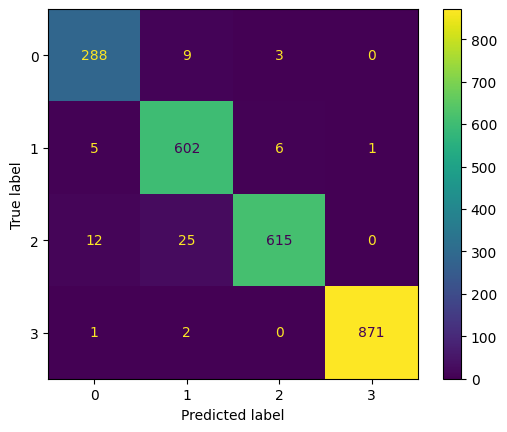

In [46]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [23]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [47]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5]

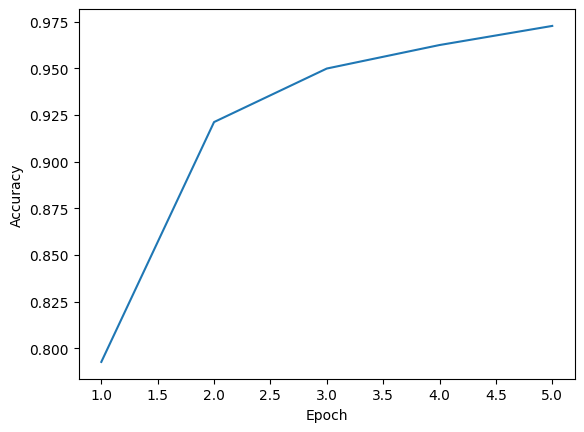

In [48]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.show()

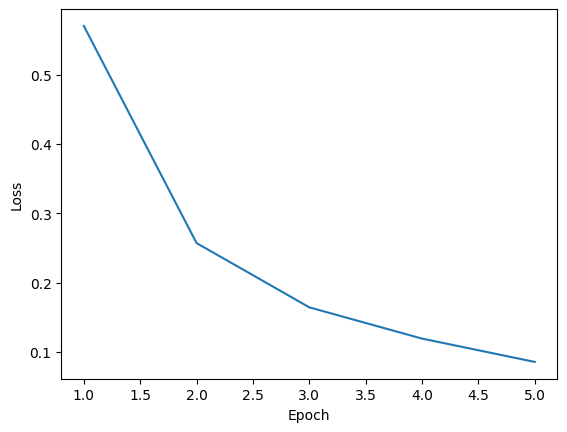

In [49]:
#
# Display loss history
#
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.show()

# Protein Sequence Classification

# Data Preprocessing

In [ ]:
#
# Change from sequence to int[], using mapping dict
#
amino_acid_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in amino_acid_dict.keys()):
                check = True
                break
            arr.append(amino_acid_dict[row[i]])
        if(check == False):
            results.append(arr)
    return results

In [ ]:
#
# Read data
#
protein_mers_data = read_data('/kaggle/input/protein-sequence/MERS2.fasta')
protein_sars_data = read_data('/kaggle/input/protein-sequence/SARS_PROTEIN.fasta')
protein_covid_data = read_data('/kaggle/input/protein-sequence/COVID_PROTEIN.fasta')
protein_dengue_data = read_data('/kaggle/input/protein-sequence/DENGUE_PROTEIN.fasta')

In [ ]:
#
# Encode data
#
protein_mers_encoding = data_preprocessing(protein_mers_data)
protein_sars_encoding = data_preprocessing(protein_sars_data)
protein_covid_encoding = data_preprocessing(protein_covid_data)
protein_dengue_encoding = data_preprocessing(protein_dengue_data)
# protein_influenza_encoding = data_preprocessing(protein_influenza_data)
# protein_hepatitis_encoding = data_preprocessing(protein_hepatitis_data)

In [ ]:
#
# Create label for each disease
#
protein_mers_label = [0] * len(protein_mers_encoding)
protein_sars_label = [1] * len(protein_sars_encoding)
protein_covid_label = [2] * len(protein_covid_encoding)
# protein_influenza_label = [3] * len(protein_influenza_encoding)
protein_dengue_label = [3] * len(protein_dengue_encoding)
# protein_hepatitis_label = [5] * len(protein_hepatitis_encoding)

In [ ]:
#
# Create data in form of 'DataFrame'
#
protein_train_data = pd.DataFrame({'protein': protein_mers_encoding + protein_sars_encoding + protein_covid_encoding + protein_dengue_encoding ,
                           'label': protein_mers_label + protein_sars_label + protein_covid_label + protein_dengue_label})
protein_train_data.head()

In [ ]:
#
# Drop duplicate sequences
#
protein_train_data.drop_duplicates(subset=['protein'], inplace=True)
protein_train_data.head()

In [ ]:
#
# Statistic per label
#
sns.countplot(data=protein_train_data, x = 'label')

In [ ]:
#
# Get max_length to pad sequence
#
# protein_max_length = int(max([len(x) for x in protein_train_data['protein']]))
protein_max_length = 2000
protein_max_length

# Create model

In [ ]:
import keras
from keras import layers
import tensorflow as tf
# A simpleRNN without any pretrained embeddings and one dense layer
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=protein_max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train model

In [ ]:
#
# Padding sequences
#
protein_data_padding = pad_sequences(protein_train_data['protein'], maxlen=protein_max_length,value=0,padding='post')

In [ ]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(protein_train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [ ]:
#
# Splitting data
#
protein_train, protein_test, label_train, label_test = train_test_split(protein_data_padding, y_tf, test_size = 0.2, random_state=42)

In [ ]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(protein_train ,label_train, batch_size=32, epochs=5)

# Test model

In [ ]:
test_prediction = model.predict(protein_test)
test_prediction[0]

In [ ]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [ ]:
print(classification_report(test_pre, test_label))

In [ ]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [ ]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [ ]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

In [ ]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.show()

#
# Display loss history
#
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his, color = 'red')
plt.show()

# **K-mer Encoding**

# DNA Sequence Classification

# *Preprocessing data*

In [ ]:
k_mer = 10
def k_merEncoding(data):
    data = data_preprocessing(data)
    max_length = 1000
    dataPadding = pad_sequences(data, maxlen=max_length,value=0,padding='post')
    dataPadding = list(dataPadding)
    for i in range(len(dataPadding)):
        k_merEncode = [dataPadding[i][j:j+k_mer] for j in range(0, len(dataPadding[i]) - k_mer)]
        dataPadding[i] = k_merEncode
    return dataPadding

In [10]:
#
# K-mer Encoding data
#
mers_k_mer_encoding = k_merEncoding(mers_data)
sars_k_mer_encoding = k_merEncoding(sars_data[:3000])
covid_k_mer_encoding = k_merEncoding(covid_data)
dengue_k_mer_encoding = k_merEncoding(dengue_data)

In [12]:
#
# Labeling data
#
mers_label = [0] * len(mers_k_mer_encoding)
sars_label = [1] * len(sars_k_mer_encoding)
covid_label = [2] * len(covid_k_mer_encoding)
dengue_label = [3] * len(dengue_k_mer_encoding)

In [13]:
#
# Create data with DataFrame format
#
train_data = pd.DataFrame({'dna': mers_k_mer_encoding + sars_k_mer_encoding + covid_k_mer_encoding + dengue_k_mer_encoding, 'label': mers_label + sars_label + covid_label +dengue_label})
train_data.head()

,dna,label
0,"[[1, 1, 1, 4, 4, 1, 1, 4, 1, 2], [1, 1, 4, 4, ...",0
1,"[[1, 2, 4, 1, 4, 1, 3, 2, 4, 3], [2, 4, 1, 4, ...",0
2,"[[3, 1, 2, 1, 1, 1, 3, 4, 2, 1], [1, 2, 1, 1, ...",0
3,"[[1, 1, 4, 4, 4, 3, 4, 4, 4, 3], [1, 4, 4, 4, ...",0
4,"[[1, 1, 4, 4, 4, 3, 4, 4, 4, 3], [1, 4, 4, 4, ...",0


In [14]:
#
# get max_length to padding sequence 
# Note that: Devide 2 because devices are not enough :v bruh
#
# max_length = int(max([len(x) for x in train_data['dna']]) / 3)
max_length = 1000
max_length

1000

# *Create modal*

In [15]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(990, 10, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 988, 8, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 494, 4, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 492, 2, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 246, 1, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,015,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,098,948 (8.01 MB)

 Trainable params: 2,098,948 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

# *Train model*

In [16]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [17]:
#
# Convert list to numpy array
#
data = np.array([np.array(x) for x in train_data['dna']])

In [18]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data, y_tf, test_size = 0.2, random_state=42)

In [19]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(dna_train ,label_train, batch_size=32, epochs=5)

Epoch 1/5


2024-04-25 01:00:03.673728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1317: 0.693169, expected 0.499944
2024-04-25 01:00:03.673784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1392: 0.655281, expected 0.462057
2024-04-25 01:00:03.673852: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6712: 0.839061, expected 0.645837
2024-04-25 01:00:03.673874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7904: 2.80479, expected 2.27354
2024-04-25 01:00:03.673885: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7905: 3.18922, expected 2.65796
2024-04-25 01:00:03.673896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7906: 2.88474, expected 2.35348
2024-04-25 01:00:03.673907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7907: 2.88551, expected 2.35425
2024-04-25 01:00:03.673917: 

 20/305 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4317 - loss: 1.3038

I0000 00:00:1714006807.716300      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6742 - loss: 0.8198
Epoch 2/5
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9108 - loss: 0.2728
Epoch 3/5
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9476 - loss: 0.1660
Epoch 4/5
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9649 - loss: 0.1166
Epoch 5/5
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9780 - loss: 0.0698


# *Test model*

In [ ]:
test_prediction = model.predict(dna_test)
test_prediction[0]

In [21]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [22]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       285
           1       0.97      0.94      0.95       632
           2       0.94      0.94      0.94       651
           3       0.99      0.99      0.99       872

    accuracy                           0.96      2440
   macro avg       0.95      0.96      0.95      2440
weighted avg       0.96      0.96      0.96      2440



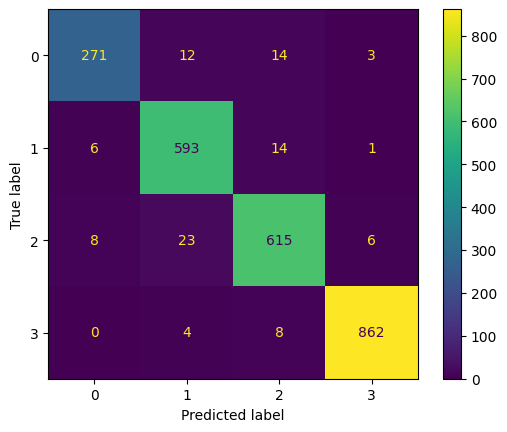

In [23]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [25]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [26]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5]

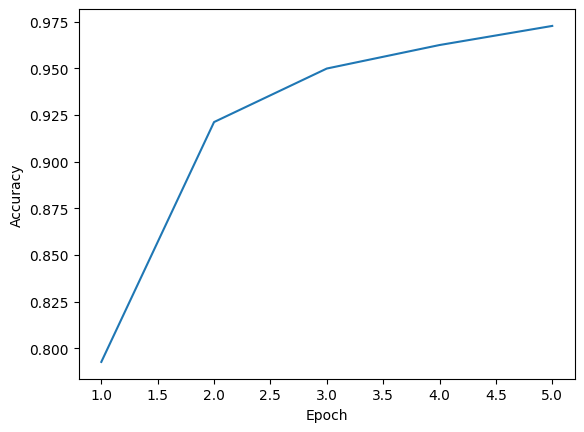

In [27]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.show()

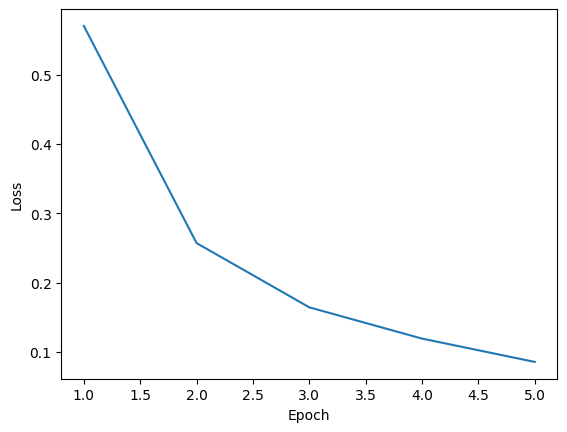

In [28]:
#
# Display loss history
#
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.show()

# Rolling

In [ ]:
# import keras
# from keras import layers
# from keras.layers import TimeDistributed
# import tensorflow as tf
# # A simpleRNN without any pretrained embeddings and one dense layer
# optimizers = tf.keras.optimizers.Adam(learning_rate = 0.005, use_ema=True)

# cnn_lstm_model = keras.Sequential()
# cnn_lstm_model.add(layers.Embedding(input_dim=max_length,output_dim=8))
# # cnn_lstm_model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
# # cnn_lstm_model.add(layers.MaxPooling1D(pool_size=2))
# # cnn_lstm_model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# # cnn_lstm_model.add(layers.MaxPooling1D(pool_size=2))

# # cnn_lstm_model.add(layers.LSTM(units=128, activation='tanh', unit_forget_bias=False))

# cnn_lstm_model.add(layers.Flatten())
# cnn_lstm_model.add(layers.Dense(units=256, activation='relu'))
# # cnn_lstm_model.add(layers.Dense(units=128, activation='relu'))
# cnn_lstm_model.add(layers.Dense(units=4, activation='softmax'))

# cnn_lstm_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

# cnn_lstm_model.summary()

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# data_padding, label = ros.fit_resample(data_padding, train_data['label'])

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=300,max_depth=14)
# clf.fit(dna_train, label_train)

In [ ]:
# label_pre = clf.predict(dna_test)
# print(classification_report(label_pre,label_test))
# print(accuracy_score(label_pre,label_test)*100)

In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy_score(test_pre, test_label)

In [ ]:
# mers_data_test = read_data('/kaggle/input/dna-sequence-testing/SARS_TEST.fasta')
# mers_data_encoding = data_preprocessing(mers_data_test)

# influenza_data_test = read_data('/kaggle/input/dna-sequence-testing/INFLUENZA_TEST.fasta')
# influenza_data_encoding = data_preprocessing(influenza_data_test)

In [ ]:
# data_test = mers_data_encoding + influenza_data_encoding[:1000]

In [ ]:
# p = pad_sequences(influenza_data_encoding, maxlen=max_length,value=0,padding='post')

In [ ]:
# data_test_padding = pad_sequences(data_test, maxlen=max_length,value=0,padding='post')

In [ ]:
# import
# loaded_model = keras.saving.load_model("model.keras")

In [ ]:
# results = model.predict(p)
# results[:3]

In [ ]:
# pre = np.argmax(results, axis = 1)
# pre[:3]

In [ ]:
# actual_results = [1] * len(mers_data_encoding) + [3] * 1000

In [ ]:
# unique, counts = np.unique(pre, return_counts=True)
# dict(zip(unique, counts))

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# typeClass = ['CNN','CNN','CNN-LSTM','CNN-LSTM']
# typeEval = ['Label Encoding Training', 'Label Encoding Testing', 'Label Encoding Training', 'Label Encoding Testing']
# accuracy = [0.96, 0.92, 0.95, 0.93]
# accuracy_table = pd.DataFrame({'type': typeClass, 'typeEval': typeEval, 'accuracy': accuracy})

# sns.barplot(data = accuracy_table, x='typeEval', y='accuracy',hue = 'type', saturation=1, palette = "mako")
# plt.xlabel('')
# plt.ylabel('Accuracy (%)')
# plt.show()